# Trajectory optimization with 4d wind field

In [1]:
import warnings

import fastmeteo
import matplotlib.pyplot as plt

import numpy as np
import openap
import pandas as pd
from openap import top

warnings.filterwarnings("ignore")


## airports and aircraft


In [2]:
actype = "A320"
origin = "EHAM"
destination = "LGAV"
m0 = 0.85

o = openap.nav.airport(origin)
d = openap.nav.airport(destination)

latmin = min(o["lat"], d["lat"]) - 2
latmax = max(o["lat"], d["lat"]) + 2
lonmin = min(o["lon"], d["lon"]) - 2
lonmax = max(o["lon"], d["lon"]) + 2


## wind data

We will use fastmeteo to get the wind field data


In [3]:
latitudes = np.linspace(latmin, latmax, 20)
longitudes = np.linspace(lonmin, lonmax, 20)
altitudes = np.linspace(1000, 45000, 30)
timestamps = pd.date_range("2021-05-01 08:00:00", "2021-05-01 15:00:00", freq="1H")

latitudes, longitudes, altitudes, times = np.meshgrid(
    latitudes, longitudes, altitudes, timestamps
)

grid = pd.DataFrame().assign(
    latitude=latitudes.flatten(),
    longitude=longitudes.flatten(),
    altitude=altitudes.flatten(),
    timestamp=times.flatten(),
)

fmg = fastmeteo.Grid(local_store="/tmp/era5-zarr")

wind = fmg.interpolate(grid)


In [4]:
wind.head()

,latitude,longitude,altitude,timestamp,u_component_of_wind,v_component_of_wind,temperature,specific_humidity
0,35.92351,2.7463,1000.0,2021-05-01 08:00:00,2.662002,-0.268155,287.403343,0.007505
1,35.92351,2.7463,1000.0,2021-05-01 09:00:00,2.610650,0.375755,288.403605,0.006770
2,35.92351,2.7463,1000.0,2021-05-01 10:00:00,3.806022,0.308188,289.144232,0.006112
3,35.92351,2.7463,1000.0,2021-05-01 11:00:00,3.865915,-0.590817,290.408359,0.005582
4,35.92351,2.7463,1000.0,2021-05-01 12:00:00,4.224836,-1.288765,291.951893,0.005171


## Optimize

reformat the wind dataframe columns before using it in the optimization


In [5]:
wind = (
    wind.rename(columns={"u_component_of_wind": "u", "v_component_of_wind": "v"})
    .assign(ts=lambda x: (x.timestamp - x.timestamp.iloc[0]).dt.total_seconds())
    .eval("h=altitude * 0.3048")
)

optimizer = top.CompleteFlight(actype, origin, destination, m0)
optimizer.enable_wind(wind)
flight = optimizer.trajectory(objective="fuel")


<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.11/site-packages/matplotlib/pyplot.py'>

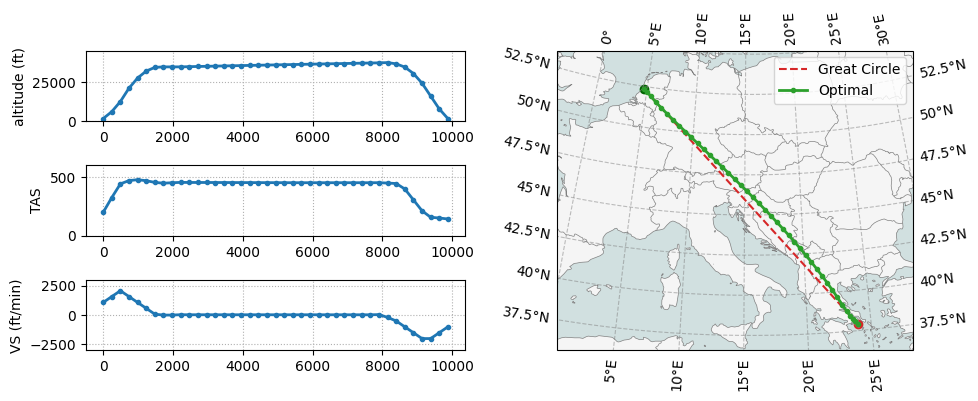

In [6]:
top.vis.trajectory(flight)
